# Download Data and Packages

In [1]:
! wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
! wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

# ! wget http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat
# ! wget http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat

# ! wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
# ! wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

! pip install spectral
! pip install torch-summary

--2020-11-02 17:14:00--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   584KB/s    in 11s     

2020-11-02 17:14:12 (511 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2020-11-02 17:14:12--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K) [text/plain]
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2020-11-02 17:14:13 (182 MB/s) - ‘Indian_pines_gt.

# Import Dependencies

In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv
from keras.utils import to_categorical

from plotly.offline import init_notebook_mode

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.io as sio
import os
import spectral

from google.colab import files

init_notebook_mode(connected=True)
%matplotlib inline

In [3]:
DATASET = 'IP'
TEST_RATIO = 0.90
WINDOW_SIZE = 15
COMPONENTS = 30 if DATASET == 'IP' else 15
CLASSES = 9 if (DATASET == 'PU' or DATASET == 'PC') else 16
TRANSFORMATIONS = 2
TRANSFORMATION_KERNEL = 3

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda") if CUDA else torch.device("cpu")

LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 100
EXPERIMENTS = 5

if DATASET == 'IP':
    TARGET_NAMES = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                    ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                    'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                    'Stone-Steel-Towers']
elif DATASET == 'SA':
    TARGET_NAMES = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                    'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                    'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                    'Vinyard_untrained','Vinyard_vertical_trellis']
elif DATASET == 'PU':
    TARGET_NAMES = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                    'Self-Blocking Bricks','Shadows']

FILENAME = DATASET+'_WindowSize_'+str(WINDOW_SIZE)+'_TestRatio_'+str(TEST_RATIO)+'_Transformations_'+str(TRANSFORMATIONS)+'_Kernel_'+str(TRANSFORMATION_KERNEL)

In [4]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join('Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join('Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join('Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join('Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join('PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join('PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=WINDOW_SIZE, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
def create_train_test_data():
    X, y = loadData(DATASET)

    X, pca = applyPCA(X, numComponents=COMPONENTS)
    X, y = createImageCubes(X, y, windowSize=WINDOW_SIZE)

    Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, TEST_RATIO)
    return Xtrain, Xtest, ytrain, ytest

In [10]:
class HSIDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, index):
    X = torch.Tensor(self.X[index]).permute(2, 0, 1)
    y = to_categorical(self.y[index], num_classes=CLASSES)

    data = {'image':X, 'label':y}

    return data

In [11]:
def create_dataloaders(batch_size=BATCH_SIZE):
  Xtrain, Xtest, ytrain, ytest = create_train_test_data()

  train_set = HSIDataset(Xtrain, ytrain)
  test_set = HSIDataset(Xtest, ytest)

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

In [12]:
train_loader, test_loader = create_dataloaders(batch_size=BATCH_SIZE)

# Define Model

In [13]:
class GhostModule(nn.Module):
    def __init__(self, inp, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        self.oup = oup
        self.ratio = ratio

        init_channels = math.ceil(oup / ratio)
        new_channels = init_channels*(ratio-1)

        self.primary_conv = nn.Sequential(
            nn.Conv2d(inp, init_channels, kernel_size, stride, kernel_size//2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential(),
        )

        if ratio > 1 :
          self.cheap_operation = nn.Sequential(
              nn.Conv2d(init_channels, new_channels, dw_size, 1, dw_size//2, groups=init_channels, bias=False),
              nn.BatchNorm2d(new_channels),
              nn.ReLU(inplace=True) if relu else nn.Sequential(),
          )

    def forward(self, x):
        x1 = self.primary_conv(x)

        if self.ratio > 1:
          x2 = self.cheap_operation(x1)

          out = torch.cat([x1, x2], dim=1)
        else:
          out = x1

        return out[:, :self.oup, :, :]

In [14]:
class GhoMR(nn.Module):
  def __init__(self, inplanes, output, baseWidth=12, scale = 4, ratio=2, dw_size=3):
    super(GhoMR, self).__init__()

    self.scale = scale
    self.baseWidth  = baseWidth

    self.ghost1 = GhostModule(inplanes, baseWidth * scale, kernel_size=1, ratio=ratio, dw_size=dw_size)

    if scale == 1:
      self.nums = 1
    else:
      self.nums = scale -1

    gblocks = []

    for i in range(self.nums):
      gblocks.append(GhostModule(baseWidth, baseWidth, kernel_size=3, ratio=ratio, dw_size=dw_size))

    self.gblocks = nn.ModuleList(gblocks)

    self.ghost2 = GhostModule(baseWidth * scale, output, kernel_size=1, ratio=ratio, dw_size=dw_size, relu=False)

    if (inplanes == output):
        self.shortcut = nn.Sequential()
    else:
        self.shortcut = nn.Sequential(
            nn.Conv2d(inplanes, inplanes, kernel_size=3, stride=1, padding=1, groups=inplanes, bias=False),
            nn.BatchNorm2d(inplanes),
            nn.Conv2d(inplanes, output, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(output),
        )    

  def forward(self, x):
    residual = x
  
    out = self.ghost1(x)

    spx = torch.split(out, self.baseWidth, 1)

    for i in range(self.nums):
      if i == 0 :
        sp = spx[i]
      else:
        sp = sp + spx[i]

      sp = self.gblocks[i](sp)

      if i == 0:
        out = sp
      else:
        out = torch.cat((out, sp), 1)

    if self.scale != 1 :
      out = torch.cat((out, spx[self.nums]), 1)

    out = self.ghost2(out)

    out += self.shortcut(residual)
    return out

In [15]:
class GhoMRNet(nn.Module):
  def __init__(self, channels, classes=CLASSES, baseWidth=12, scale=4, ratio=2, dw_size=3):
    super(GhoMRNet, self).__init__()

    self.conv = nn.Sequential(
            nn.Conv2d(COMPONENTS, channels[0], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels[0]),
            nn.ReLU(inplace=True),
        )
    
    blocks = []
    inp = channels[0]

    for c in channels[1:]:
      blocks.append(GhoMR(inp, c, baseWidth=baseWidth, scale=scale, ratio=ratio, dw_size=dw_size))
      inp = c

    self.blocks = nn.ModuleList(blocks)    

    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Linear(inp, classes)

  def forward(self, x):
    x = self.conv(x)

    for block in self.blocks:
      x = block(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [16]:
channels = [24, 24, 36, 48, 60]
model = GhoMRNet(channels=channels, baseWidth=12, scale=4, ratio=TRANSFORMATIONS, dw_size=TRANSFORMATION_KERNEL).to(DEVICE)
summary(model, input_size=(30, 15, 15), verbose=0)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       6,480
|    └─BatchNorm2d: 2-2                  48
|    └─ReLU: 2-3                         --
├─ModuleList: 1-2                        --
|    └─GhoMR: 2-4                        --
|    |    └─GhostModule: 3-1             888
|    |    └─ModuleList: 3-2              2,178
|    |    └─GhostModule: 3-3             732
|    |    └─Sequential: 3-4              --
|    └─GhoMR: 2-5                        --
|    |    └─GhostModule: 3-5             888
|    |    └─ModuleList: 3-6              2,178
|    |    └─GhostModule: 3-7             1,098
|    |    └─Sequential: 3-8              1,200
|    └─GhoMR: 2-6                        --
|    |    └─GhostModule: 3-9             1,176
|    |    └─ModuleList: 3-10             2,178
|    |    └─GhostModule: 3-11            1,464
|    |    └─Sequential: 3-12             2,220
|    └─GhoMR: 2-7                        

# Model Training

In [17]:
def test_model(model, test_loader, criterion, device):
  test_accuracy = 0
  test_loss = 0
  true_labels = []
  pred_labels = []

  model.eval()
  with torch.no_grad():
    for batch in test_loader:
      image_batch = batch['image'].to(device)
      label_batch = batch['label'].to(device)
      _, label_batch = torch.max(label_batch, 1)

      y_pred = model(image_batch)
      batch_loss = criterion(y_pred, label_batch)

      _, output_labels = torch.max(y_pred, 1)
      correct = label_batch.eq(output_labels).cpu().numpy()

      test_accuracy += sum(correct)
      test_loss += batch_loss.item() * image_batch.size(0)

      true_labels += list(label_batch.cpu().numpy())
      pred_labels += list(output_labels.cpu().numpy())

  average_testing_loss = test_loss / len(test_loader.sampler)
  average_testing_accuracy = test_accuracy / len(test_loader.sampler)

  return average_testing_loss, average_testing_accuracy, true_labels, pred_labels

In [18]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs, device, save_path):
  min_train_loss = np.inf

  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []

  for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    train_accuracy = 0
    test_accuracy = 0

    model.train()
    for batch in train_loader:
      image_batch = batch['image'].to(device)
      label_batch = batch['label'].to(device)
      _, label_batch = torch.max(label_batch, 1)

      optimizer.zero_grad()
      y_pred = model(image_batch)
      batch_loss = criterion(y_pred, label_batch)
      batch_loss.backward()
      optimizer.step()

      _, output_labels = torch.max(y_pred, 1)
      correct = label_batch.eq(output_labels).cpu().numpy()
      train_accuracy += sum(correct)
      train_loss += batch_loss.item() * image_batch.size(0)

    average_training_loss = train_loss / len(train_loader.sampler)
    average_training_accuracy = train_accuracy / len(train_loader.sampler)

    average_testing_loss, average_testing_accuracy, _, _ = test_model(
        model, test_loader, 
        criterion, device
        )    
    
    train_losses.append(average_training_loss)
    test_losses.append(average_testing_loss)
    train_accuracies.append(average_training_accuracy)
    test_accuracies.append(average_testing_accuracy)
    
    if min_train_loss > average_training_loss :
      print('Saving at Epoch: {} \t Train Loss: {:.6f} \t Test Loss: {:.6f} \t Train Accuracy: {:.4f} \t Test Accuracy: {:.4f}'.format(epoch, average_training_loss, average_testing_loss, average_training_accuracy, average_testing_accuracy))
      #print('Training Loss Improved - Saving Model')
      
      min_train_loss = average_training_loss
      torch.save(model.state_dict(), save_path)      
  
  return train_losses, test_losses, train_accuracies, test_accuracies


In [19]:
import random

def random_seed(n):
  torch.manual_seed(n)
  np.random.seed(n)
  random.seed(n)

  if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [20]:
train_loader, test_loader = create_dataloaders(batch_size=BATCH_SIZE)

In [21]:
for e in range(EXPERIMENTS):
  random_seed(e)
  print("Training Experiment "+str(e+1))

  channels = [24, 24, 36, 48, 60]
  model = GhoMRNet(channels=channels, baseWidth=12, scale=4, ratio=TRANSFORMATIONS, dw_size=TRANSFORMATION_KERNEL).to(DEVICE)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

  save_path = FILENAME+'_Experiment_'+str(e+1)+'.pt'

  train_losses, test_losses, train_accuracies, test_accuracies = train_model(
      model=model, 
      train_loader=train_loader, 
      test_loader=test_loader, 
      optimizer=optimizer, 
      criterion=criterion, 
      epochs=EPOCHS, 
      device=DEVICE,
      save_path=save_path
      )
  print("")
  break

Training Experiment 1
Saving at Epoch: 0 	 Train Loss: 2.451745 	 Test Loss: 2.636355 	 Train Accuracy: 0.3525 	 Test Accuracy: 0.2396
Saving at Epoch: 1 	 Train Loss: 1.647591 	 Test Loss: 2.335200 	 Train Accuracy: 0.5645 	 Test Accuracy: 0.2599
Saving at Epoch: 2 	 Train Loss: 1.146353 	 Test Loss: 1.408953 	 Train Accuracy: 0.6963 	 Test Accuracy: 0.5207
Saving at Epoch: 3 	 Train Loss: 0.832616 	 Test Loss: 0.774768 	 Train Accuracy: 0.7725 	 Test Accuracy: 0.7655
Saving at Epoch: 4 	 Train Loss: 0.611344 	 Test Loss: 0.497822 	 Train Accuracy: 0.8418 	 Test Accuracy: 0.8722
Saving at Epoch: 5 	 Train Loss: 0.422799 	 Test Loss: 0.357999 	 Train Accuracy: 0.9160 	 Test Accuracy: 0.9241
Saving at Epoch: 6 	 Train Loss: 0.304221 	 Test Loss: 0.252860 	 Train Accuracy: 0.9541 	 Test Accuracy: 0.9416
Saving at Epoch: 7 	 Train Loss: 0.225190 	 Test Loss: 0.260640 	 Train Accuracy: 0.9668 	 Test Accuracy: 0.9440
Saving at Epoch: 8 	 Train Loss: 0.198946 	 Test Loss: 0.220504 	 Train Ac

# Model Validation

In [22]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)

    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    each_acc_dict = dict(zip(TARGET_NAMES, each_acc*100))

    average_acc = np.mean(each_acc)
    return each_acc_dict, average_acc

In [23]:
def reports(y_pred, y_true):    
    c_report = classification_report(y_true, y_pred, digits=4, target_names=TARGET_NAMES)
    oa = accuracy_score(y_true, y_pred)

    confusion = confusion_matrix(y_true, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)

    kappa = cohen_kappa_score(y_true, y_pred)    
    return c_report, confusion, oa*100, each_acc, aa*100, kappa*100

In [24]:
def generate_results(c_report, each_acc, kappa, oa, aa, file_name = "classification_report.txt"):

  file_name = os.path.join("Results", file_name)

  c_report = str(c_report)
  each_acc = str(each_acc)

  with open(file_name, 'w') as x_file:
      x_file.write('\n')
      x_file.write('{} Kappa accuracy (%)'.format(kappa))
      x_file.write('\n')
      x_file.write('{} Overall accuracy (%)'.format(oa))
      x_file.write('\n')
      x_file.write('{} Average accuracy (%)'.format(aa))
      x_file.write('\n')
      x_file.write('\n')
      x_file.write('Classification Report - \n')
      x_file.write('{}'.format(c_report))
      x_file.write('\n')
      x_file.write('\n')
      x_file.write('Class-Wise Accuracies - \n')
      x_file.write('{}'.format(each_acc))

In [25]:
def generate_confusion_matrix(cm, filename="cm.png"):
  filename = os.path.join("Results", filename)
  sb.set(font_scale=1)

  plt.figure(figsize=(14, 14))
  plt.axis('on')
  sb.heatmap(cm, annot=True, fmt="d", linewidths=0, xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)

  plt.savefig(filename)
  plt.show()

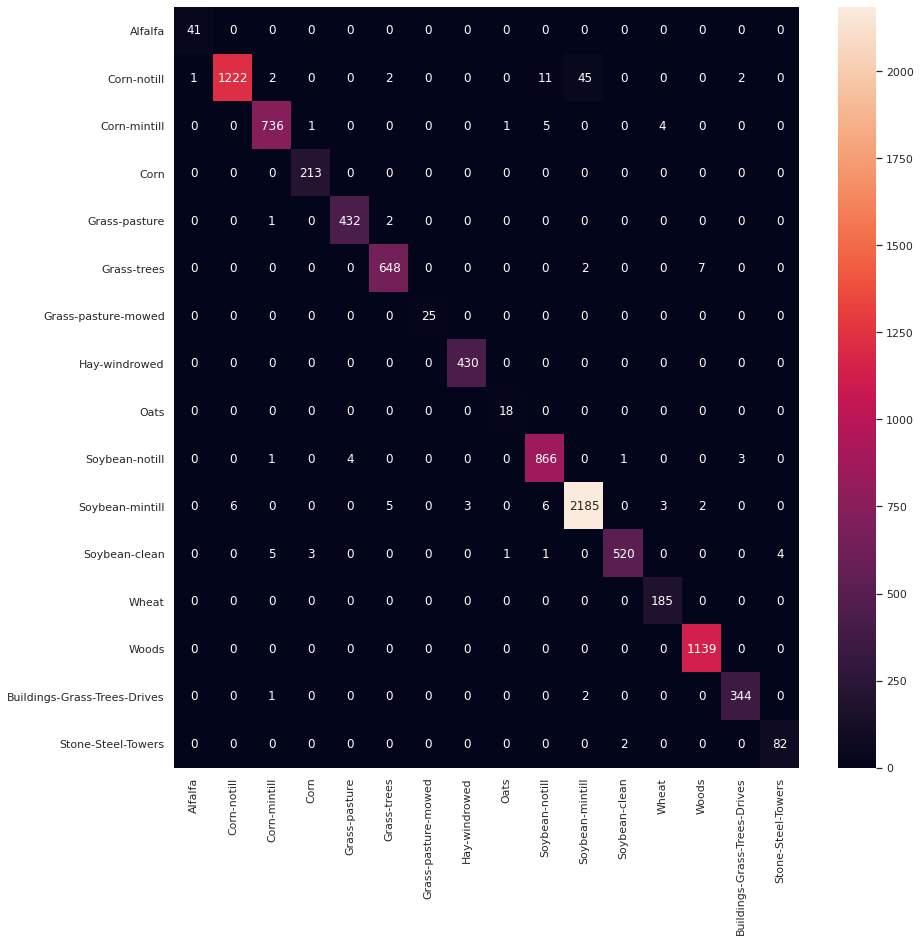

Generated results for Experiment 1


In [26]:
if not os.path.exists("Results"):
    os.makedirs("Results")

for e in range(EXPERIMENTS):
  model = GhoMRNet(channels=channels, baseWidth=12, scale=4, ratio=TRANSFORMATIONS, dw_size=TRANSFORMATION_KERNEL).to(DEVICE)
  weights_path = FILENAME+'_Experiment_'+str(e+1)+'.pt'
  model.load_state_dict(torch.load(weights_path))

  _, _, y_true, y_pred = test_model(
        model=model, 
        test_loader=test_loader, 
        criterion=criterion, 
        device=DEVICE
        )

  c_report, confusion, oa, each_acc, aa, kappa = reports(y_pred, y_true)
  generate_results(c_report, each_acc, kappa, oa, aa, file_name=FILENAME+'_Experiment_'+str(e+1)+'.txt')
  generate_confusion_matrix(confusion, filename=FILENAME+'_Experiment_CMatrix_'+str(e+1)+'.png')
  print("Generated results for Experiment "+str(e+1))
  break

In [27]:
def Patch(data, height_index, width_index):
    height_slice = slice(height_index, height_index+WINDOW_SIZE)
    width_slice = slice(width_index, width_index+WINDOW_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [28]:
def create_predicted_image():
    model = GhoMRNet(channels=channels, baseWidth=12, scale=4, ratio=TRANSFORMATIONS, dw_size=TRANSFORMATION_KERNEL).to(DEVICE)
    weights_path = FILENAME+'_Experiment_1.pt'
    model.load_state_dict(torch.load(weights_path))

    X, y = loadData(DATASET)

    X, pca = applyPCA(X, numComponents=COMPONENTS)
    X = padWithZeros(X, WINDOW_SIZE//2)

    height = y.shape[0]
    width = y.shape[1]

    outputs = np.zeros((height,width))

    for i in range(height):
      for j in range(width):
          target = int(y[i, j])
          if target == 0 :
              continue
          else :
              image_patch = Patch(X, i, j)
              X_test_image = torch.Tensor(image_patch.astype('float32')).permute(2, 0, 1).unsqueeze(0).to(DEVICE)

              model.eval()
              prediction = np.array(model(X_test_image).cpu().argmax(axis=1)) #torch.max(model(X_test_image), 1)

              prediction = prediction[0] + 1            
              outputs[i][j] = prediction

    return y, outputs

In [29]:
y, outputs = create_predicted_image()

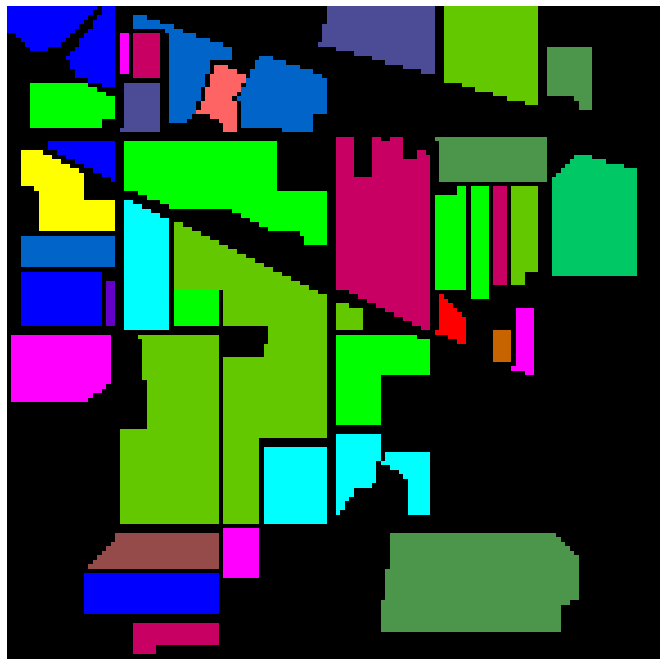

In [30]:
ground_truth = spectral.imshow(classes=y, figsize=(12,12), interpolation="none")
plt.axis("off")

filename = FILENAME+'_Experiment_1_Ground_Truth.png'
filename = os.path.join("Results", filename)

plt.savefig(filename)
plt.show()

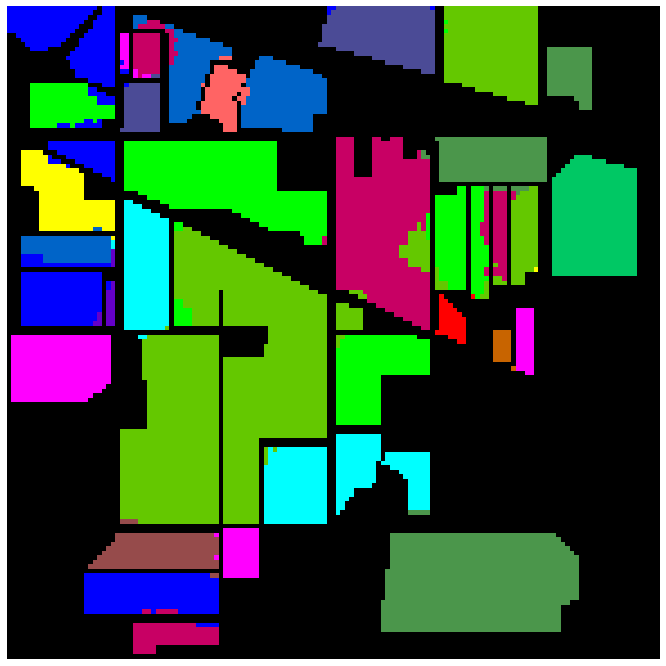

In [31]:
predict_image = spectral.imshow(classes=outputs.astype(int), figsize=(12,12), interpolation="none")
plt.axis("off")

filename = FILENAME+'_Experiment_1_Predicted.png'
filename = os.path.join("Results", filename)

plt.savefig(filename)
plt.show()

In [32]:
#spectral.save_rgb(FILENAME+".jpg", outputs.astype(int), colors=spectral.spy_colors)

In [33]:
#spectral.imshow(classes = outputs.astype(int), colors=spectral.spy_colors)

# T-SNE Visualization

In [34]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [35]:
model = GhoMRNet(channels=channels, baseWidth=12, scale=4, ratio=TRANSFORMATIONS, dw_size=TRANSFORMATION_KERNEL).to(DEVICE)
weights_path = FILENAME+'_Experiment_1.pt'
model.load_state_dict(torch.load(weights_path))

model.avgpool.register_forward_hook(get_activation('avgpool'))
features = np.empty((0, channels[-1]))
labels = np.empty((0))

model.eval()
with torch.no_grad():
  for batch in test_loader:
      image_batch = batch['image'].to(DEVICE)
      label_batch = batch['label'].to(DEVICE)
      
      output = model(image_batch)
      _, batch_labels = torch.max(label_batch, 1)

      batch_features = activation['avgpool'].squeeze(-1).squeeze(-1).cpu().numpy()
      batch_labels = [TARGET_NAMES[int(l)] for l in batch_labels.cpu().numpy()]

      features = np.concatenate((features, batch_features))
      labels = np.concatenate((labels, batch_labels))


In [36]:
tsne = TSNE(n_components=2, perplexity=50).fit_transform(features)

In [37]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

def generate_tsne_plot(tsne, filename='Tsne.png'):
  filename = os.path.join("Results", filename)

  tx = tsne[:, 0]
  ty = tsne[:, 1]

  tx_scaled = scale_to_01_range(tx)
  ty_scaled = scale_to_01_range(ty)

  plt.figure(figsize=(12, 12))
  sb.set(font_scale=1.2)

  sb.scatterplot(tx_scaled, ty_scaled, hue=labels, legend='full', palette=sb.color_palette("bright", len(TARGET_NAMES)))
  plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
  plt.grid(b=None)

  plt.savefig(filename, bbox_inches='tight') #, bbox_inches='tight'
  plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



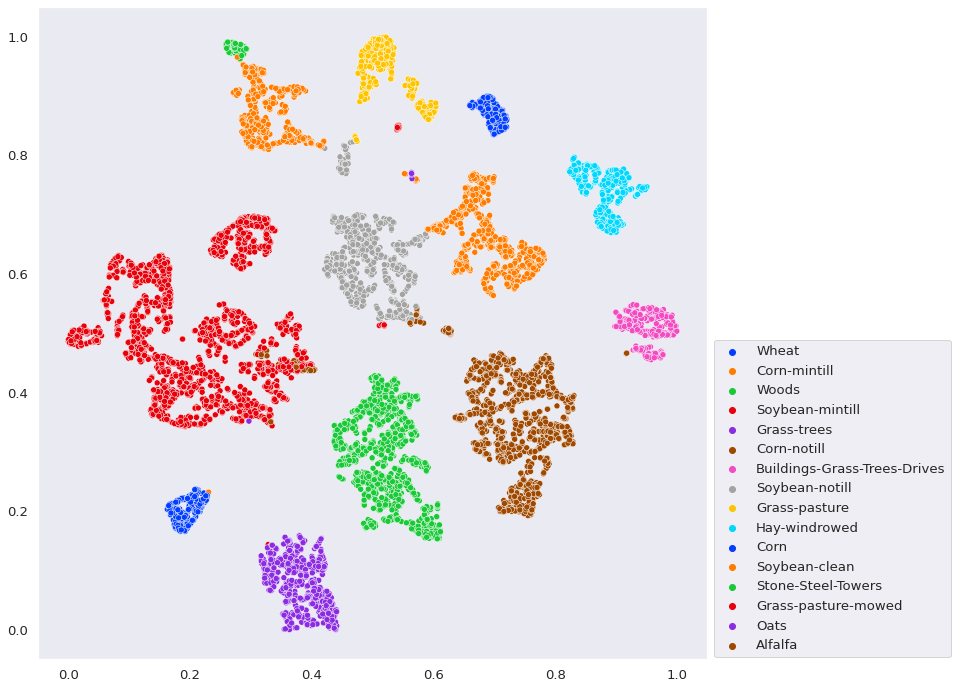

In [38]:
generate_tsne_plot(tsne, filename=FILENAME+'_Experiment_1_Tsne.png')